# Keystroke Predictor across different keyboards

This notebook aims to preprocess and train recorded keystrokes across different keyboard types(mechanical, scissor) to predict, with atleast an 80% accuracy, the correct key that was pressed on the keyboard. Audio files will be cut based upon detected pulses after normalizing each audio file. Training will utilize a fusion neural network that will learn both the Mel-Spectrum format of the recorded audio data and tabular data that defines the switches used for additional input. It will run through five different experiments to accomplish this. INSERT **HYPOTHESIS HERE**

This notebook will run through the preprocessing of recorded keystroke data across various types of keyboards, such as scissor keyboards from a macbook and two types of mechanical keyboard switches: Halo Trues and Cherry MX Speed Silver. Once preprocessed, the CoATNet Fusion model will run an 80/20 training and testing split on the audio data with 47 total classes.

Three types of data are recorded.

1. Old data: Data for User1 and User2. Using first iteration of keyboard_recorder.
2. New Data: New data recorded after the new keyboard_recorder was made, considered User3.
3. research: Originally from the KeyStroke dataset used in the paper. Only the non-Zoom audio. Considered User4.

Steps for pulling together data

1. Load the data folders
2. Preprocess the files by extracting keystrokes (personal method vs Keystroke method)
3. Encode and format data together across all folders.

By the end of the notebook, a `preprocessed_data` folder will appear that has all of the required audio files, a pickle file of tabular data linking to this file will appear, and graphs and metrics will be printed in the notebook to show training curves. Classification Matrices will also be displayed for the different keys.



-------------
Begin preprocessing data

In [16]:
# Preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import yaml
import librosa
import librosa.display
import soundfile as sf
import shutil
import torch
import glob
from tabulate import tabulate

from data_processors import old_data_processing, extract_keystrokes,\
    combine_for_train_and_test, create_experiments
from plotting import plot_losses

# Training
from coat_w_fusion import \
    coatnet_mm_train, coatnet_mm_infer

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

### Old Data before keyboard_recorder rework (User1, User2)

In [17]:
# Define the path to the data folder
data_folder = '../data/old_data/'
output_dir='../preprocessed_data/'

key_df = old_data_processing(data_folder=data_folder,
                             output_dir=output_dir)

# Display the DataFrame
key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,name,switch_color,timestamp,user,audio_file,key_pressed
0,0.18,0.18,0.09,0.09,44100.0,0,1,Keychron Q3,80%_Tenkeyless,mechanical,2,0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1720064310,User2,key_press_apost_1720064310_User2.wav,apost
1,0.18,0.18,0.09,0.09,44100.0,0,1,Keychron Q3,80%_Tenkeyless,mechanical,2,0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1720064656,User2,key_press_n_1720064656_User2.wav,n
2,0.18,0.18,0.09,0.09,44100.0,0,1,Keychron Q3,80%_Tenkeyless,mechanical,2,0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1720062576,User2,key_press_8_1720062576_User2.wav,8
3,0.18,0.18,0.09,0.09,44100.0,0,1,Keychron Q3,80%_Tenkeyless,mechanical,2,0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1720062683,User2,key_press_0_1720062683_User2.wav,0
4,0.18,0.18,0.09,0.09,44100.0,0,1,Keychron Q3,80%_Tenkeyless,mechanical,2,0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1720064347,User2,key_press_z_1720064347_User2.wav,z


### New Data

Find the peak for each audio file, then seperate them out.

In [18]:
# Extract keystrokes with the chosen threshold
audio_path='../data/new_data/'
low_threshold=0.005  # Thresholds must be adjusted
high_threshold=0.01  # Thresholds must be adjusted
output_dir='../preprocessed_data/'
window_size=35
target_duration=1.0
debug=False
give_plot=False

new_key_df = extract_keystrokes(
    data_folder=audio_path,
    low_threshold=low_threshold,
    high_threshold=high_threshold,
    output_dir=output_dir,
    window_size=window_size,
    target_duration=target_duration,
    debug=False,
    give_plot=False
)
new_key_df.head()

,keyboard_name,keyboard_size,keyboard_type,switch_color,audio_file,key_pressed
0,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_0_User3.wav,`
1,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_1_User3.wav,`
2,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_2_User3.wav,`
3,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_3_User3.wav,`
4,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_4_User3.wav,`


-------------

### Research Data (User4)

Same processing as User 3

In [19]:
# Extract keystrokes with the chosen threshold
audio_path='../data/research/'
low_threshold=0.005  # Thresholds must be adjusted
high_threshold=0.01  # Thresholds must be adjusted
output_dir='../preprocessed_data/'
window_size=35
target_duration=1.0
debug=False
give_plot=False

research_df = extract_keystrokes(
    data_folder=audio_path,
    low_threshold=low_threshold,
    high_threshold=high_threshold,
    output_dir=output_dir,
    window_size=window_size,
    target_duration=target_duration,
    debug=False,
    give_plot=False
)
research_df.head()

,keyboard_name,keyboard_size,keyboard_type,switch_color,audio_file,key_pressed
0,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_0_User4.wav,5
1,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_1_User4.wav,5
2,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_2_User4.wav,5
3,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_3_User4.wav,5
4,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_4_User4.wav,5


### Prepare data for training and testing

Combines dataframes, preprocesses them, and creates a pkl file of the tabular feature data for the linear portion of the code.

In [20]:
combined_key_df, path_to_pkl = combine_for_train_and_test(
    [key_df, new_key_df, research_df],
    output_dir=output_dir
)

Number of tabular items: 1840
Number of audio files in the folder: 1840
Matching shapes. Outputting tabular pickle file.


In [21]:
combined_key_df.head()

,keyboard_size,audio_file,switch_type_Linear,switch_type_None,switch_type_Tactile
0,3,key_press_apost_1720064310_User2.wav,True,False,False
1,3,key_press_n_1720064656_User2.wav,True,False,False
2,3,key_press_8_1720062576_User2.wav,True,False,False
3,3,key_press_0_1720062683_User2.wav,True,False,False
4,3,key_press_z_1720064347_User2.wav,True,False,False


-------
Create folders for each experiment

In [22]:
experiment_folders, experiment_1_df, experiment_2_df, \
    experiment_3_df, experiment_4_df, experiment_5_df = \
        create_experiments(processed_data=output_dir, path_to_pkl=path_to_pkl)

Generated Experiment #1 at ../preprocessed_data/experiment_1/
Matching shapes. Outputting tabular pickle file.
Generated Experiment #2 at ../preprocessed_data/experiment_2/
Matching shapes. Outputting tabular pickle file.
Generated Experiment #3 at ../preprocessed_data/experiment_3/
Generated Experiment #4 at ../preprocessed_data/experiment_4/
Generated Experiment #5 at ../preprocessed_data/experiment_5/


--------

## Training

In [23]:
batch_size=16 #16
split_size=0.2
learn_rate=5e-5
# epochs=1100
epochs_experiment_1=250
epochs_experiment_2=60
epochs_experiment_3=500
epochs_experiment_4=300
epochs_experiment_5=500

### Experiment 1: All data + classes

In [24]:
experiment_1_df.head()

,keyboard_size,audio_file,switch_type_Linear,switch_type_None,switch_type_Tactile
0,3,key_press_apost_1720064310_User2.wav,True,False,False
1,3,key_press_n_1720064656_User2.wav,True,False,False
2,3,key_press_8_1720062576_User2.wav,True,False,False
3,3,key_press_0_1720062683_User2.wav,True,False,False
4,3,key_press_z_1720064347_User2.wav,True,False,False


In [25]:
print(experiment_1_df.shape)

(1840, 5)


In [26]:
experiment_num = experiment_folders[0][-2]
audio_dir = experiment_folders[0]
tabular_file = audio_dir + 'keyboard_tabular_data.pkl'
model_path = f'../models/model_exp{experiment_num}.pt'

if not os.path.exists(f'../models/models_{experiment_num}/'):
        os.makedirs(f'../models/models_{experiment_num}/')

last_model_1, train_loss_1, val_loss_1, val_acc_1 = coatnet_mm_train.train(
        audio_dir=audio_dir,
        tabular_pkl_file=tabular_file,
        model_path=model_path,
        experiment=experiment_num,
        batch_size=batch_size,
        split_size=split_size,
        learn_rate=learn_rate,
        epochs=epochs_experiment_1)

print(f'Experiment #{experiment_num} Validation Accuracy: {val_acc_1:.2f} ')

/home/mreag/miniconda3/envs/aaml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


correct/total:10/368 = 0.02717391304347826
Epoch [1/250] || Train Loss: 4.1221 || Val Loss: 3.9006 || Val Accuracy: 0.0272
correct/total:7/368 = 0.019021739130434784
Epoch [2/250] || Train Loss: 3.9072 || Val Loss: 4.0064 || Val Accuracy: 0.0190
correct/total:9/368 = 0.024456521739130436
Epoch [3/250] || Train Loss: 3.9233 || Val Loss: 3.8846 || Val Accuracy: 0.0245
correct/total:9/368 = 0.024456521739130436
Epoch [4/250] || Train Loss: 3.9501 || Val Loss: 3.9621 || Val Accuracy: 0.0245
correct/total:12/368 = 0.03260869565217391
Epoch [5/250] || Train Loss: 4.0413 || Val Loss: 3.7728 || Val Accuracy: 0.0326
correct/total:14/368 = 0.03804347826086957
Epoch [6/250] || Train Loss: 3.8267 || Val Loss: 3.8636 || Val Accuracy: 0.0380
correct/total:13/368 = 0.035326086956521736
Epoch [7/250] || Train Loss: 3.9205 || Val Loss: 3.9076 || Val Accuracy: 0.0353
correct/total:12/368 = 0.03260869565217391
Epoch [8/250] || Train Loss: 3.7819 || Val Loss: 3.8678 || Val Accuracy: 0.0326
correct/total:1

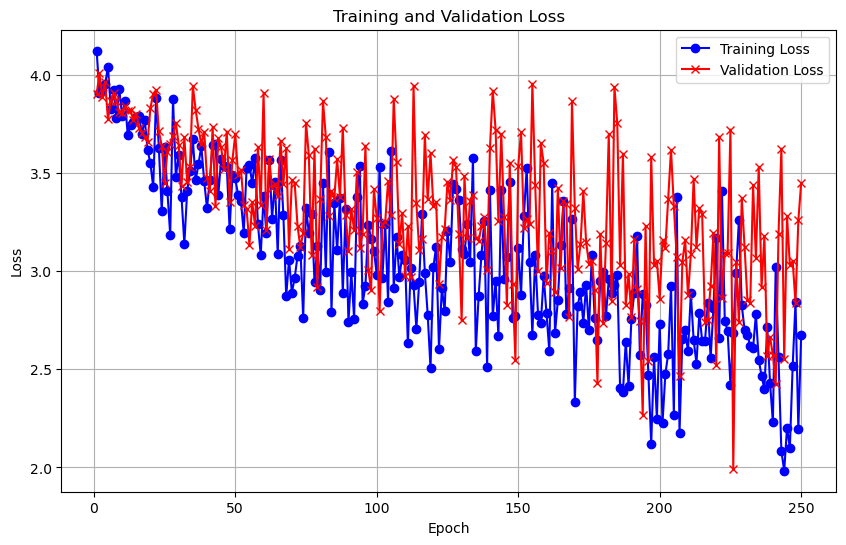

In [27]:
plot_losses(training_losses=train_loss_1,
            validation_losses=val_loss_1,
            epochs=list(range(1, len(train_loss_1) + 1)))

### Experiment 2: User1 Only dataset(DropCTRLV1 Tactile Keys). All Classes

In [28]:
experiment_2_df.head()

,keyboard_size,audio_file,switch_type_Linear,switch_type_None,switch_type_Tactile
480,3,key_press_z_1720383597_User1.wav,False,False,True
481,3,key_press_k_1720383403_User1.wav,False,False,True
482,3,key_press_4_1720380835_User1.wav,False,False,True
483,3,key_press_f_1720383189_User1.wav,False,False,True
484,3,key_press_d_1720383147_User1.wav,False,False,True


In [29]:
print(experiment_2_df.shape)
print(experiment_2_df[experiment_2_df['audio_file'].str.contains('User1')].shape[0])

(480, 5)
480


In [30]:
experiment_num = experiment_folders[1][-2]
audio_dir = experiment_folders[1]
tabular_file = audio_dir + 'keyboard_tabular_data.pkl'
model_path = f'../models/model_exp{experiment_num}.pt'

if not os.path.exists(f'../models/models_{experiment_num}/'):
        os.makedirs(f'../models/models_{experiment_num}/')

last_model_2, train_loss_2, val_loss_2, val_acc_2 = coatnet_mm_train.train(
        audio_dir=audio_dir,
        tabular_pkl_file=tabular_file,
        model_path=model_path,
        experiment=experiment_num,
        batch_size=batch_size,
        split_size=split_size,
        learn_rate=learn_rate,
        epochs=epochs_experiment_2)

print(f'Experiment #{experiment_num} Validation Accuracy: {val_acc_2:.2f} ')

/home/mreag/miniconda3/envs/aaml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


correct/total:2/96 = 0.020833333333333332
Epoch [1/60] || Train Loss: 4.5109 || Val Loss: 4.4548 || Val Accuracy: 0.0208
correct/total:1/96 = 0.010416666666666666
Epoch [2/60] || Train Loss: 4.2826 || Val Loss: 4.2428 || Val Accuracy: 0.0104
correct/total:1/96 = 0.010416666666666666
Epoch [3/60] || Train Loss: 4.3308 || Val Loss: 4.2140 || Val Accuracy: 0.0104
correct/total:1/96 = 0.010416666666666666
Epoch [4/60] || Train Loss: 3.9649 || Val Loss: 3.9806 || Val Accuracy: 0.0104
correct/total:1/96 = 0.010416666666666666
Epoch [5/60] || Train Loss: 3.9975 || Val Loss: 3.8335 || Val Accuracy: 0.0104
correct/total:1/96 = 0.010416666666666666
Epoch [6/60] || Train Loss: 3.9786 || Val Loss: 3.9581 || Val Accuracy: 0.0104
correct/total:1/96 = 0.010416666666666666
Epoch [7/60] || Train Loss: 3.8021 || Val Loss: 3.8102 || Val Accuracy: 0.0104
correct/total:1/96 = 0.010416666666666666
Epoch [8/60] || Train Loss: 3.8908 || Val Loss: 3.9019 || Val Accuracy: 0.0104
correct/total:0/96 = 0.0
Epoch [

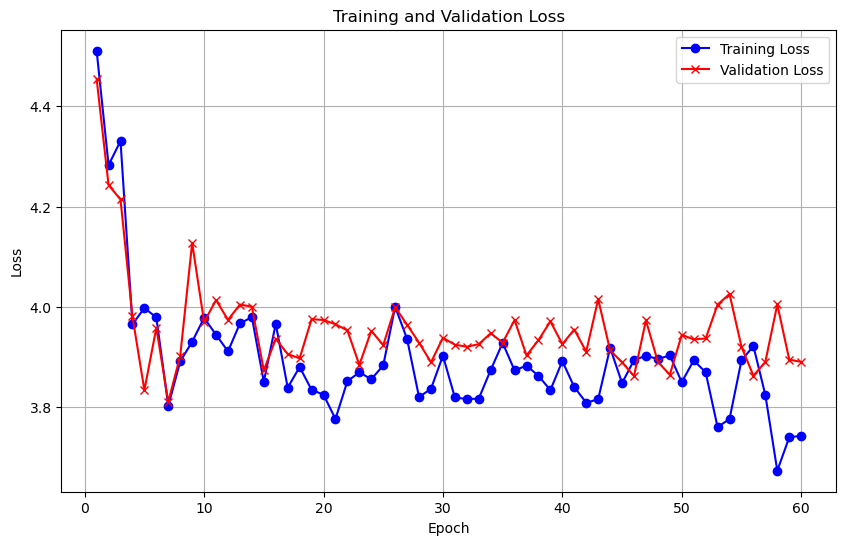

In [31]:
plot_losses(training_losses=train_loss_2,
            validation_losses=val_loss_2,
            epochs=list(range(1, len(train_loss_2) + 1)))

### Experiment 3: Binary classification. Predict only 'h' with all datasets

In [32]:
experiment_3_df.head()

,keyboard_size,audio_file,switch_type_Linear,switch_type_None,switch_type_Tactile
0,3,key_press_noth_0_1720064310_User2.wav,True,False,False
1,3,key_press_noth_1_1720064656_User2.wav,True,False,False
2,3,key_press_noth_2_1720062576_User2.wav,True,False,False
3,3,key_press_noth_3_1720062683_User2.wav,True,False,False
4,3,key_press_noth_4_1720064347_User2.wav,True,False,False


In [33]:
print(experiment_3_df.shape)

(1840, 5)


In [34]:
experiment_num = experiment_folders[2][-2]
audio_dir = experiment_folders[2]
tabular_file = audio_dir + 'keyboard_tabular_data.pkl'
model_path = f'../models/model_exp{experiment_num}.pt'

if not os.path.exists(f'../models/models_{experiment_num}/'):
        os.makedirs(f'../models/models_{experiment_num}/')

last_model_3, train_loss_3, val_loss_3, val_acc_3 = coatnet_mm_train.train(
        audio_dir=audio_dir,
        tabular_pkl_file=tabular_file,
        model_path=model_path,
        experiment=experiment_num,
        batch_size=batch_size,
        split_size=split_size,
        learn_rate=learn_rate,
        epochs=epochs_experiment_3)

print(f'Experiment #{experiment_num} Validation Accuracy: {val_acc_3:.2f} ')

/home/mreag/miniconda3/envs/aaml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


correct/total:361/368 = 0.9809782608695652
Epoch [1/500] || Train Loss: 0.2716 || Val Loss: 0.0881 || Val Accuracy: 0.9810
correct/total:361/368 = 0.9809782608695652
Epoch [2/500] || Train Loss: 0.0380 || Val Loss: 0.0707 || Val Accuracy: 0.9810
correct/total:361/368 = 0.9809782608695652
Epoch [3/500] || Train Loss: 0.4657 || Val Loss: 0.0558 || Val Accuracy: 0.9810
correct/total:361/368 = 0.9809782608695652
Epoch [4/500] || Train Loss: 0.4455 || Val Loss: 0.0494 || Val Accuracy: 0.9810
correct/total:361/368 = 0.9809782608695652
Epoch [5/500] || Train Loss: 0.0347 || Val Loss: 0.0634 || Val Accuracy: 0.9810
correct/total:361/368 = 0.9809782608695652
Epoch [6/500] || Train Loss: 0.2367 || Val Loss: 0.0478 || Val Accuracy: 0.9810
correct/total:361/368 = 0.9809782608695652
Epoch [7/500] || Train Loss: 0.0278 || Val Loss: 0.2374 || Val Accuracy: 0.9810
correct/total:361/368 = 0.9809782608695652
Epoch [8/500] || Train Loss: 0.2188 || Val Loss: 0.0548 || Val Accuracy: 0.9810
correct/total:36

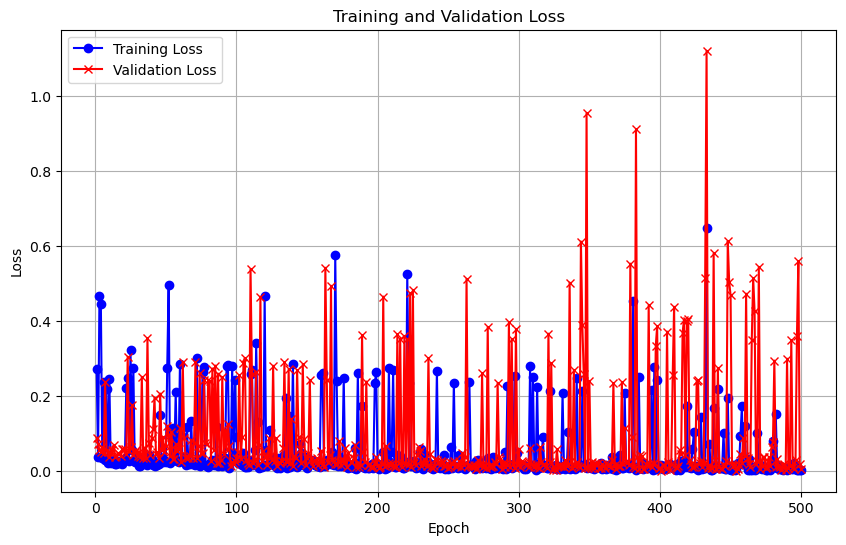

In [35]:
plot_losses(training_losses=train_loss_3,
            validation_losses=val_loss_3,
            epochs=list(range(1, len(train_loss_3) + 1)))

### Experiment 4: Binary classification. Predict only 'h' with only Drop dataset

In [36]:
experiment_4_df.head()

,index,keyboard_size,audio_file,switch_type_Linear,switch_type_None,switch_type_Tactile
0,480,3,key_press_noth_0_1720383597_User1.wav,False,False,True
1,481,3,key_press_noth_1_1720383403_User1.wav,False,False,True
2,482,3,key_press_noth_2_1720380835_User1.wav,False,False,True
3,483,3,key_press_noth_3_1720383189_User1.wav,False,False,True
4,484,3,key_press_noth_4_1720383147_User1.wav,False,False,True


In [37]:
print(experiment_4_df.shape)

(480, 6)


In [38]:
experiment_num = experiment_folders[3][-2]
audio_dir = experiment_folders[3]
tabular_file = audio_dir + 'keyboard_tabular_data.pkl'
model_path = f'../models/model_exp{experiment_num}.pt'

if not os.path.exists(f'../models/models_{experiment_num}/'):
        os.makedirs(f'../models/models_{experiment_num}/')

last_model_4, train_loss_4, val_loss_4, val_acc_4 = coatnet_mm_train.train(
        audio_dir=audio_dir,
        tabular_pkl_file=tabular_file,
        model_path=model_path,
        experiment=experiment_num,
        batch_size=batch_size,
        split_size=split_size,
        learn_rate=learn_rate,
        epochs=epochs_experiment_4)

print(f'Experiment #{experiment_num} Validation Accuracy: {val_acc_4:.2f} ')

/home/mreag/miniconda3/envs/aaml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


correct/total:93/96 = 0.96875
Epoch [1/300] || Train Loss: 0.2348 || Val Loss: 0.2417 || Val Accuracy: 0.9688
correct/total:93/96 = 0.96875
Epoch [2/300] || Train Loss: 0.2838 || Val Loss: 0.2891 || Val Accuracy: 0.9688
correct/total:93/96 = 0.96875
Epoch [3/300] || Train Loss: 0.2481 || Val Loss: 0.0189 || Val Accuracy: 0.9688
correct/total:93/96 = 0.96875
Epoch [4/300] || Train Loss: 0.0212 || Val Loss: 0.0238 || Val Accuracy: 0.9688
correct/total:93/96 = 0.96875
Epoch [5/300] || Train Loss: 0.0203 || Val Loss: 0.0216 || Val Accuracy: 0.9688
correct/total:93/96 = 0.96875
Epoch [6/300] || Train Loss: 0.0195 || Val Loss: 0.2446 || Val Accuracy: 0.9688
correct/total:93/96 = 0.96875
Epoch [7/300] || Train Loss: 0.0183 || Val Loss: 0.2789 || Val Accuracy: 0.9688
correct/total:93/96 = 0.96875
Epoch [8/300] || Train Loss: 0.0161 || Val Loss: 0.0155 || Val Accuracy: 0.9688
correct/total:93/96 = 0.96875
Epoch [9/300] || Train Loss: 0.3019 || Val Loss: 0.0187 || Val Accuracy: 0.9688
correct/to

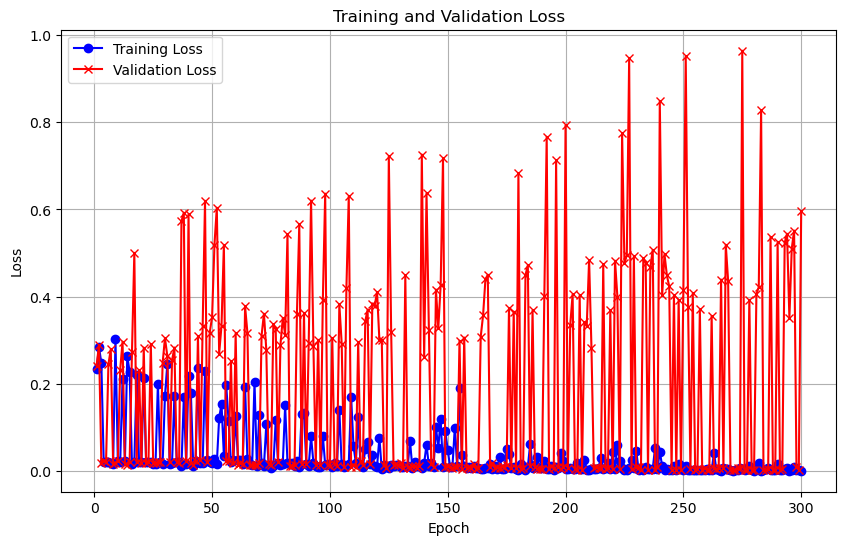

In [39]:
plot_losses(training_losses=train_loss_4,
            validation_losses=val_loss_4,
            epochs=list(range(1, len(train_loss_4) + 1)))

### Experiment 5: Binary classification. Predict only 'space' with only Drop dataset

In [40]:
experiment_5_df.head()

,index,keyboard_size,audio_file,switch_type_Linear,switch_type_None,switch_type_Tactile
0,480,3,key_press_notspace_0_1720383597_User1.wav,False,False,True
1,481,3,key_press_notspace_1_1720383403_User1.wav,False,False,True
2,482,3,key_press_notspace_2_1720380835_User1.wav,False,False,True
3,483,3,key_press_notspace_3_1720383189_User1.wav,False,False,True
4,484,3,key_press_notspace_4_1720383147_User1.wav,False,False,True


In [41]:
experiment_num = experiment_folders[4][-2]
audio_dir = experiment_folders[4]
tabular_file = audio_dir + 'keyboard_tabular_data.pkl'
model_path = f'../models/model_exp{experiment_num}.pt'

if not os.path.exists(f'../models/models_{experiment_num}/'):
        os.makedirs(f'../models/models_{experiment_num}/')

last_model_5, train_loss_5, val_loss_5, val_acc_5 = coatnet_mm_train.train(
        audio_dir=audio_dir,
        tabular_pkl_file=tabular_file,
        model_path=model_path,
        experiment=experiment_num,
        batch_size=batch_size,
        split_size=split_size,
        learn_rate=learn_rate,
        epochs=epochs_experiment_5)

print(f'Experiment #{experiment_num} Validation Accuracy: {val_acc_5:.2f} ')

/home/mreag/miniconda3/envs/aaml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


correct/total:89/96 = 0.9270833333333334
Epoch [1/500] || Train Loss: 0.1288 || Val Loss: 0.3538 || Val Accuracy: 0.9271
correct/total:91/96 = 0.9479166666666666
Epoch [2/500] || Train Loss: 0.2615 || Val Loss: 0.2217 || Val Accuracy: 0.9479
correct/total:91/96 = 0.9479166666666666
Epoch [3/500] || Train Loss: 0.0219 || Val Loss: 0.2468 || Val Accuracy: 0.9479
correct/total:91/96 = 0.9479166666666666
Epoch [4/500] || Train Loss: 0.0169 || Val Loss: 0.0297 || Val Accuracy: 0.9479
correct/total:91/96 = 0.9479166666666666
Epoch [5/500] || Train Loss: 0.0188 || Val Loss: 0.3228 || Val Accuracy: 0.9479
correct/total:91/96 = 0.9479166666666666
Epoch [6/500] || Train Loss: 0.0209 || Val Loss: 0.5473 || Val Accuracy: 0.9479
correct/total:91/96 = 0.9479166666666666
Epoch [7/500] || Train Loss: 0.2714 || Val Loss: 0.2619 || Val Accuracy: 0.9479
correct/total:91/96 = 0.9479166666666666
Epoch [8/500] || Train Loss: 0.0140 || Val Loss: 0.0174 || Val Accuracy: 0.9479
correct/total:91/96 = 0.94791666

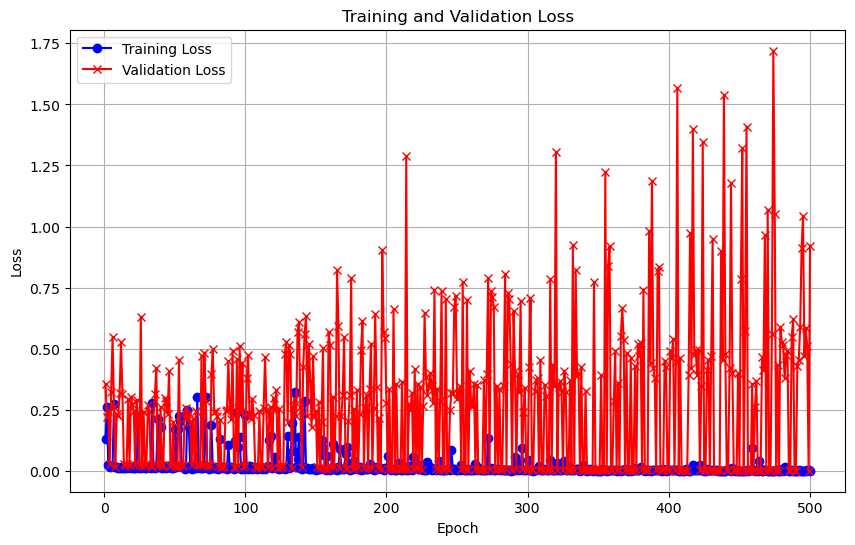

In [42]:
plot_losses(training_losses=train_loss_5,
            validation_losses=val_loss_5,
            epochs=list(range(1, len(train_loss_5) + 1)))

## Final Accuracy

In [43]:
acc_df = pd.DataFrame(data={
    'Experiment': ['Experiment #1', 'Experiment #2', 'Experiment #3', 'Experiment #4', 'Experiment #5'],
    'Accuracy': [val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5]
})

acc_df.head()

,Experiment,Accuracy
0,Experiment #1,0.236413
1,Experiment #2,0.010417
2,Experiment #3,0.986413
3,Experiment #4,0.968750
4,Experiment #5,0.947917


In [44]:
table = tabulate(acc_df, headers='keys', tablefmt='pretty')

print(table)

+---+---------------+----------------------+
|   |  Experiment   |       Accuracy       |
+---+---------------+----------------------+
| 0 | Experiment #1 | 0.23641304347826086  |
| 1 | Experiment #2 | 0.010416666666666666 |
| 2 | Experiment #3 |  0.9864130434782609  |
| 3 | Experiment #4 |       0.96875        |
| 4 | Experiment #5 |  0.9479166666666666  |
+---+---------------+----------------------+
